In [1]:
import numpy as np
import h5py
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#Read the HP5 file
hf = h5py.File('/content/drive/MyDrive/Colab Notebooks/vel3_cutout_rnn_ms.h5', 'r')

In [3]:
a = len(list(hf.keys())) - 3

In [4]:
def readsave(arg1,arg2):
  n1 = np.array(arg1[arg2][:])
  return n1

In [5]:
n = np.array([])
for i in range(a):
  n1 = readsave(hf,list(hf.keys())[i])
  n1 = n1.swapaxes(0,2)
  n1 = n1[0,:,:,0].reshape(n1.shape[0]**2)
  n1 = n1[:,np.newaxis]
  if i == 0:
    n = n1
  else:
    n = np.append(n,n1,axis=1)
    #print(n.shape)

In [6]:
n.shape

(16384, 128)

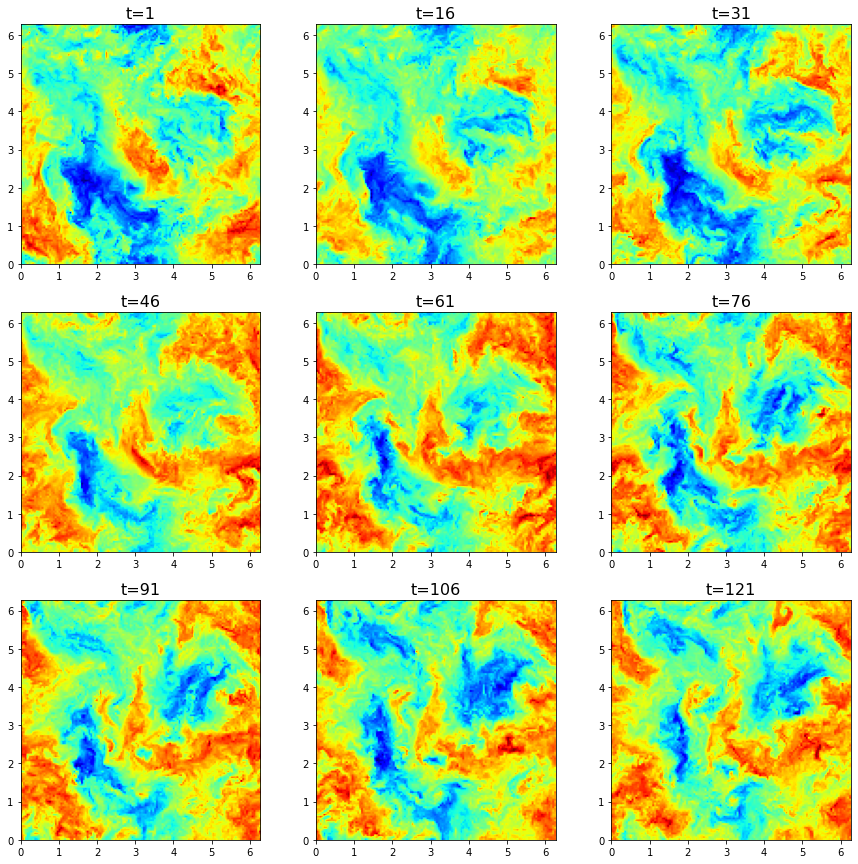

In [7]:
#Plot time evolution of ux along the y-z axis
%matplotlib inline
import matplotlib.pyplot as plt

a = int(n.shape[0]**(1/2))
fig = plt.figure(figsize = (15, 15))

count=0
for i in range(0,n.shape[1]-1,15):
  count+=1
  b = fig.add_subplot('33' + str(count))
  b.imshow(n[:,i].reshape(a,a),extent = [0, 6.28, 0, 6.28],cmap='jet')
  b.set_title('t=' + str(i+1),fontsize=16)

In [8]:
#Setup multiple scales
scale_low = range(0,n.shape[1]-1,8)
scale_med = range(0,n.shape[1]-1,4)
print(list(scale_low),list(scale_med))

[0, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120] [0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 84, 88, 92, 96, 100, 104, 108, 112, 116, 120, 124]


In [10]:
#Setup Input and Output for lower scales
nn_input_low = n[:,list(scale_low)[0:-1]].transpose()
nn_output_low = n[:,list(scale_low)[1:]].transpose()

nn_input_med = n[:,list(scale_med)[0:-1]].transpose()
nn_output_med = n[:,list(scale_med)[1:]].transpose()

nn_input_med = np.repeat(nn_input_med,4,axis=0)
nn_output_med = np.repeat(nn_output_med,4,axis=0)

nn_input_low = np.repeat(nn_input_low,8,axis=0)
nn_output_low = np.repeat(nn_output_low,8,axis=0)

print(nn_input_med.shape,nn_output_med.shape)
print(nn_input_low.shape,nn_output_low.shape)

(124, 16384) (124, 16384)
(120, 16384) (120, 16384)


In [11]:
#Setup Input and Output that is separated by one step
nn_input = n[:,0:-1].transpose()
nn_output = n[:,1:].transpose()
print(nn_input.shape,nn_output.shape)

(127, 16384) (127, 16384)


In [12]:
#Setup validation and demean all inputs
def valid_mean(arg1,arg2):
  mean = arg1.mean(axis=0,keepdims=True)

  nn_im = arg1 - mean
  nn_om = arg2 - mean
  from sklearn.model_selection import train_test_split

  all_indices = list(range(arg1.shape[0]))

  train, dev = train_test_split(all_indices, test_size=0.2,shuffle=True)

  nn_ipm = nn_im[train,:]
  nn_idm = nn_im[dev,:]
  nn_opm = nn_om[train,:]
  nn_odm = nn_om[dev,:]

  return nn_ipm, nn_idm, nn_opm, nn_odm, mean

nn_ipm, nn_idm, nn_opm, nn_odm, mean = valid_mean(nn_input,nn_output)
nn_ipm_med, nn_idm_med, nn_opm_med, nn_odm_med, mean_med = valid_mean(nn_input_med,nn_output_med)
nn_ipm_low, nn_idm_low, nn_opm_low, nn_odm_low, mean_low = valid_mean(nn_input_low,nn_output_low)

print(nn_ipm.shape, nn_opm.shape, nn_idm.shape, nn_odm.shape)
print(nn_ipm_med.shape, nn_opm_med.shape, nn_idm_med.shape, nn_odm_med.shape)
print(nn_ipm_low.shape, nn_opm_low.shape, nn_idm_low.shape, nn_odm_low.shape)

(101, 16384) (101, 16384) (26, 16384) (26, 16384)
(99, 16384) (99, 16384) (25, 16384) (25, 16384)
(96, 16384) (96, 16384) (24, 16384) (24, 16384)


In [13]:
#Train NN to model this one timestep
def fit_nn(arg1,arg2,arg3,arg4):
  from tensorflow import keras
  from keras import layers
  from keras.models import Sequential
  from keras import optimizers
  from keras.layers import Activation
  from keras.utils.generic_utils import get_custom_objects
  from keras import backend as K

  # Build model
  deep_approx = keras.models.Sequential()
  deep_approx.add(layers.Dense(1000, input_dim=arg1.shape[1], activation='sigmoid'))
  deep_approx.add(layers.Dense(1000, activation='relu'))
  deep_approx.add(layers.Dense(1000, activation='relu'))
  deep_approx.add(layers.Dense(arg2.shape[1], activation='linear'))

  # Compile model
  deep_approx.compile(loss='mse', optimizer='adam')

  # Fit!
  History = deep_approx.fit(arg1,arg2, epochs=500,
                            validation_data=(arg3, arg4))
  return deep_approx, History

In [14]:
m1,h1 = fit_nn(nn_ipm, nn_opm, nn_idm, nn_odm)
m2,h2 = fit_nn(nn_ipm_med, nn_opm_med, nn_idm_med, nn_odm_med)
m3,h3 = fit_nn(nn_ipm_low, nn_opm_low, nn_idm_low, nn_odm_low)

Epoch 1/500
4/4 [==============================] - 3s 59ms/step - loss: 0.1344 - val_loss: 0.0994
Epoch 2/500
4/4 [==============================] - 0s 17ms/step - loss: 0.0951 - val_loss: 0.0757
Epoch 3/500
4/4 [==============================] - 0s 16ms/step - loss: 0.0699 - val_loss: 0.0661
Epoch 4/500
4/4 [==============================] - 0s 16ms/step - loss: 0.0579 - val_loss: 0.0550
Epoch 5/500
4/4 [==============================] - 0s 16ms/step - loss: 0.0479 - val_loss: 0.0482
Epoch 6/500
4/4 [==============================] - 0s 15ms/step - loss: 0.0417 - val_loss: 0.0452
Epoch 7/500
4/4 [==============================] - 0s 15ms/step - loss: 0.0375 - val_loss: 0.0417
Epoch 8/500
4/4 [==============================] - 0s 15ms/step - loss: 0.0347 - val_loss: 0.0393
Epoch 9/500
4/4 [==============================] - 0s 16ms/step - loss: 0.0335 - val_loss: 0.0359
Epoch 10/500
4/4 [==============================] - 0s 18ms/step - loss: 0.0302 - val_loss: 0.0345
Epoch 11/500
4/4 [=

In [15]:
m1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper (ModuleWrappe (None, 1000)              16385000  
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 1000)              1001000   
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 1000)              1001000   
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 16384)             16400384  
Total params: 34,787,384
Trainable params: 34,787,384
Non-trainable params: 0
_________________________________________________________________


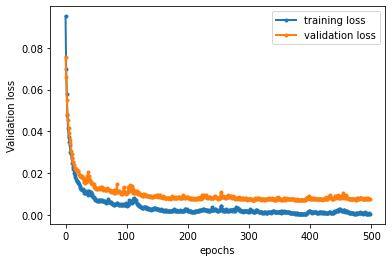

In [16]:
idx0 = 1
plt.figure()
plt.plot(h1.history['loss'][idx0:], '.-', lw=2)
plt.plot(h1.history['val_loss'][idx0:], '.-', lw=2)
plt.xlabel('epochs')
plt.ylabel('Validation loss')
plt.legend(['training loss', 'validation loss'])
plt.show()

In [17]:
nn_im = np.append(nn_ipm,nn_idm,axis=0)
nn_im_med = np.append(nn_ipm_med,nn_idm_med,axis=0)
nn_im_low = np.append(nn_ipm_low,nn_idm_low,axis=0)
print(nn_im.shape,nn_im_med.shape,nn_im_low.shape)

(127, 16384) (124, 16384) (120, 16384)


In [26]:
#Attempt reconstructing time trajectory with Multiscale Logic
nn_pred1 = np.zeros(nn_im.shape)
start1 = (nn_input-mean)[0,:][np.newaxis,:]
t1 = nn_im.shape[0]
nn_pred1[0,:] = start1

t4 = int(nn_im_med.shape[0]/4)
nn_pred4 = start1

t8 = int(nn_im_low.shape[0]/8)
nn_pred8 = start1

for i in range(t8):
  nn_pred8 = np.append(nn_pred8,m3.predict(nn_pred8[i,:][np.newaxis,:]),axis=0)

for i in range(t4):
  nn_pred4 = np.append(nn_pred4,m2.predict(nn_pred4[i,:][np.newaxis,:]),axis=0)

for i in range(t1):
  if i % 8 == 0:
    #print('8',i,int(i/8))
    nn_pred1[i,:] = nn_pred8[int(i/8),:]
  elif i % 4 == 0:
    #print('4',i,int(i/4))
    nn_pred1[i,:] = nn_pred4[int(i/4),:]

for i in range(t1):
  if np.all(nn_pred1[i,:] == 0):
    #print('i',i)
    nn_pred1[i,:] = m1.predict(nn_pred1[i-1,:][np.newaxis,:])

nn_pred = nn_pred1 + mean
nn_pred = nn_pred.transpose()

In [27]:
nn_pred.shape

(16384, 127)

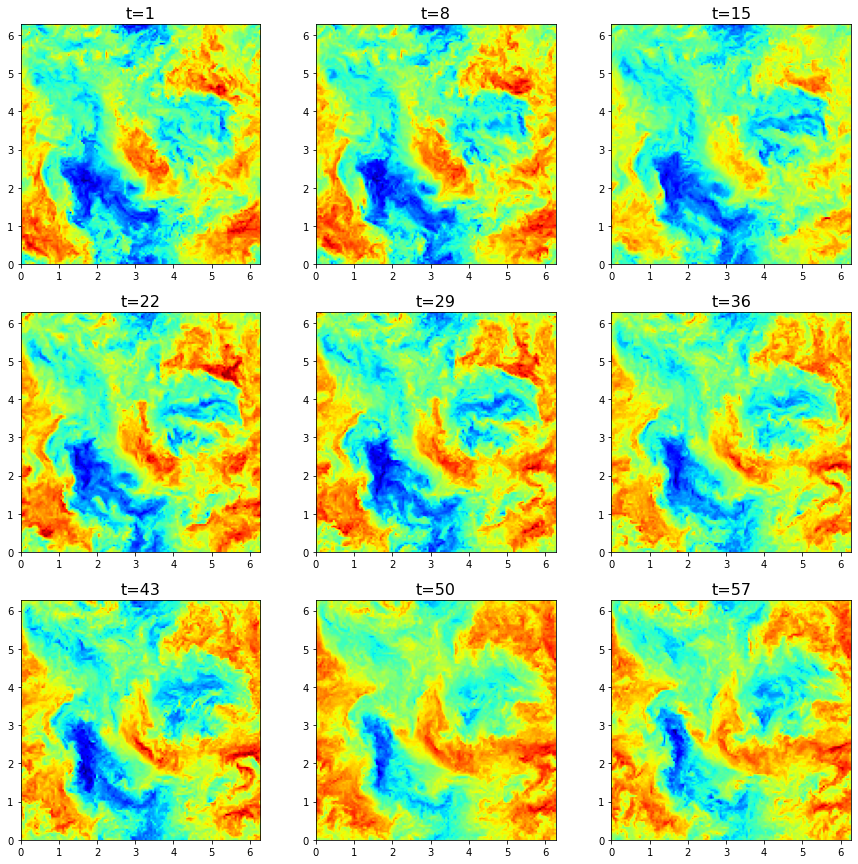

In [28]:
#Plot time evolution of ux along the y-z axis
%matplotlib inline
import matplotlib.pyplot as plt

a = int(n.shape[0]**(1/2))
fig = plt.figure(figsize = (15, 15))

count=0
for i in range(0,63,7):
  count+=1
  b = fig.add_subplot('33' + str(count))
  b.imshow(nn_pred[:,i].reshape(a,a),extent = [0, 6.28, 0, 6.28],cmap='jet')
  b.set_title('t=' + str(i+1),fontsize=16)

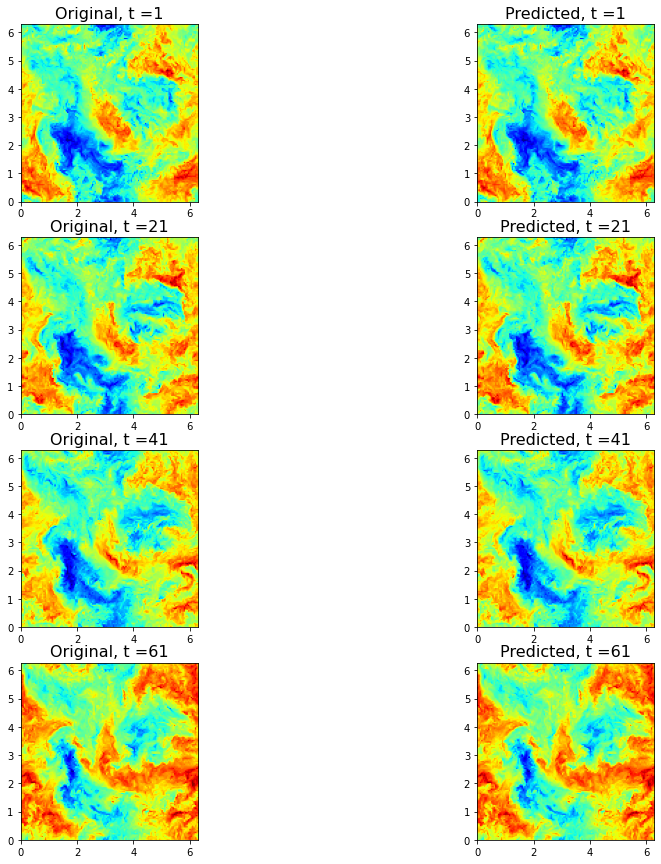

In [29]:
#Compare Actuals vs predicted
a = int(n.shape[0]**(1/2))
fig = plt.figure(figsize = (15, 15))

count=0
for i in range(0,63,20):
  count+=1
  b = fig.add_subplot('42' + str(count))
  b.imshow(n[:,i].reshape(a,a),extent = [0, 6.28, 0, 6.28],cmap='jet')
  b.set_title('Original, t =' + str(i+1),fontsize=16)
  
  count+=1
  b = fig.add_subplot('42' + str(count))
  b.imshow(nn_pred[:,i].reshape(a,a),extent = [0, 6.28, 0, 6.28],cmap='jet')
  b.set_title('Predicted, t =' + str(i+1),fontsize=16)